In [1]:
import numpy as np
from numpy import exp, log
#import scipy as sp
#import itertools
#import time
import matplotlib.pyplot as plt

from numba import jit
from time import time
from scipy.optimize import fsolve



In [2]:
# remove this later
def give_bin_ar(x, n):
    ''' gives binary representation of x in n digits as an array '''
    l = [int(d) for d in str(bin(x))[2:]]
    if len(l)<n:
        l = [0 for i in range(n-len(l))] + l
    return np.array(l)

In [3]:
def initialize_data(spin_num, sample_num):
    global n
    n=spin_num
    # Some random binary data
    global P
    P = sample_num
    
    global data 
    data = np.random.choice([-1.,1.],size=(P,n))
    

In [4]:
@jit(nopython=True)
def give_all_permutations(n):
    #all_perms = 1.*np.ones((2**n,n))
    all_perms = 1.*np.ones((2**n,n), dtype='float64')
    ran = np.arange(2**n)
    for i in range(n):
        #print(ran%(2**(i+1)))
        all_perms[ran%(2**(i+1))< 2**i,i] = -1.
    return all_perms.astype('float64')

@jit(nopython=True)
def give_H(θ, w, data):
    ''' gives 1-dim array of length P, containing H  '''
    n = w.shape[0]
    #print((data@((1-np.eye(n))*w)))
    H_int = np.sum(np.multiply((data@((1-np.eye(n))*w)), data), axis = 1)/2
    #print(H_int)
    H_loc = np.sum(data@θ, axis = 1)
    return -1.*(H_int + H_loc)
@jit
def give_dH(s, i, θ, w):
    #dH = 2*s[0,i]*θ[i] + 2*s[0,i]*np.sum(w[i]*s)
    
    dH = 2*s[0,i]*θ[i] + 2*s[0,i]*(w[i]@ s[0])
    return dH

@jit(nopython=True)
def give_BM_Pstar(θ, w, data):
    ''' returns p star, which is not normalized '''
    return np.exp(-give_H(θ, w, data))

@jit(nopython=True)
def give_Z(θ, w, data):
    ''' pass on the all permutation to get the Z '''
    Pstar = give_BM_Pstar(θ, w, data)
    Z = np.sum(Pstar)
    return Z

@jit(nopython=True)
def give_BM_P(θ, w, data):
    Pstar = give_BM_Pstar(θ, w, data)
    Z = np.sum(Pstar)
    P = Pstar/Z
    return P, Z

@jit(nopython=True)
def give_log_likelihood(θ, w, data):
    out = give_log_likelihood_data(θ, w, data)
    return np.sum(out)/data.shape[0]
@jit(nopython=True)
def give_log_likelihood_data(θ, w, data):
    p ,_ = give_BM_P(θ, w, data)
    return np.log(p)

def initialize_BM(n, option='gaussian', scale=1):
    if option=='gaussian':
        # Initial parameters of BM
        θ = np.random.normal(loc=0, scale=scale, size=(n, 1))
        w = np.random.normal(loc=0, scale=scale, size=(n, n))
        w = w + w.T
        w = w*(1-np.eye(n))

    elif option== 'uniform':
        θ = np.random.uniform(low = -1, high =1, size=(n,1))/n
        w = np.random.uniform(low = -1, high = 1, size=(n,n))
        w = (w+w.T)/(np.sqrt(n))
        w = w*(1-np.eye(n))
    
    elif option== 'costum':
        θ = np.ones((n,1))*1.0
        w = 1.0*np.ones((n,n))
        w = w*(1-np.eye(n))
            
    return θ, w

@jit(nopython=True)
def give_MH_samples(θ, w, n_samples, s0):    
    
    n = w.shape[0]
    
    sample_track = np.zeros((n_samples, n))
    
    sample = s0
    
    sample_track[0] = s0[0]
    
    H0 = give_H(θ, w, s0)
    
    #print(H0)
    #rands = np.log(np.random.rand(n_samples))
    rands = np.random.random(n_samples)
    
    flips = np.arange(n) # this is better, because you flip everything
    
    np.random.shuffle(flips)
    n_accept = 0
    
    
    for i in range(n_samples-1):
        dH = give_dH(sample , flips[i%n], θ, w)
        
        
        if dH < 0 or exp(-dH) > rands[i]:
            sample[0,flips[i%n]]*=-1
            H0 += dH
            n_accept+=1
            #print(sample[0])
        
        sample_track[i+1] = sample[0]
        
    #samples[-1] = current_sample
    #print(H0)'''
    return sample_track

#@jit(nopython=False)
def give_sigma_MF_v2(θ, w, error_criteria = 1e-15, α_MF = 0.1, maxiter = 2000):
    """
    returning <s> by mean field approximation.
    """
    # Solve the mean field equation
    m0 = np.random.uniform(1, -1, w.shape[0])
    m = fsolve(mean_field, m0, args=(θ, w), )

    # Print the magnetization


    return m

@jit(nopython=True)
def give_sigma_MF(θ, w, error_criteria = 1e-15, α_MF = 0.1, maxiter = 2000):
    """
    returning <s> by mean field approximation.
    """
    w = w*(1-np.eye(w.shape[0]))
    m = np.random.uniform(1, -1, w.shape[0])
    
    dm = error_criteria +1 # has to be larger than epsilon at the begining
    
    i=0
    while dm > error_criteria and i < maxiter:
        m_star = np.tanh(m@w + θ[0])
        dm = np.mean((m-m_star)**2)
        m = α_MF*m + (1-α_MF)*m_star
        i+=1
    #print('learned with error: ', dm)    
    return m, i # remove i
    
@jit(nopython=True)
def give_sigma_sigma_LinearResponse(w, m):
    n = w.shape[0]
    w = w*(1-np.eye(n))
    A = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            tmp = 0
            if i==j:
                #term1 = 1/((1-m[i]**2)+2e-18) #+ np.dot(w[i]**2,(1-m**2))
                tmp+= 1/((1-m[i]**2)+2e-18)
            #else:
            #    term1 = 0
            
            tmp += -w[i,j]
            #term3 = -2*m[i]*m[j]*w[i,j]**2
            A[i,j] = tmp
    χ = np.linalg.inv(A)
    
    return χ+np.outer(m,m)




# Define the spin system parameters
N = 1000      # Number of spins
J = 1.0       # Coupling constant
T = 1.0       # Temperature

# Define the mean field function
def mean_field(m, θ, w):
    
    return m - np.tanh(m@w + θ[0])



In [6]:
θ, w = initialize_BM(4)
m , i = give_sigma_MF(θ, w)
print(m)
m = give_sigma_MF_v2(θ, w)
print(m)
#print(i)
#m , i = MF(w, θ)
#print(LinearResponse(w, m))
#print(np.einsum('i,j->ij',m,m))
#print(np.outer(m,m))
#print(Lin)
#print(θ.shape)
#print(θ)
give_sigma_sigma_LinearResponse(w, m)

[ 0.45714234 -0.99208296  0.99090647  0.9999988 ]
[ 0.45714233 -0.99208296  0.99090647  0.9999988 ]


array([[ 1.00235721, -0.44776465,  0.4508075 ,  0.45714   ],
       [-0.44776465,  1.00004183, -0.98309421, -0.99208197],
       [ 0.4508075 , -0.98309421,  1.000006  ,  0.99090531],
       [ 0.45714   , -0.99208197,  0.99090531,  1.        ]])

In [7]:
class BM():
    def __init__(self, data):
        self._data = data
        self._n = data.shape[1]
        self._P = data.shape[0]
        # all permutations
        self._all_permutations = give_all_permutations(self._n)
        self._all_correlations  = np.einsum('ki, kj-> kij',self._all_permutations,self._all_permutations)
        
    def learn(self, η=0.01, max_bm_it=1000, scale=1, α=0.99, initialize_option='gaussian', tolerance=1e-13, method='exact', option=None):
        self.convergence = False
        self.tolerance = tolerance
        θ, w = initialize_BM(self._n,option=initialize_option)
        self._clamped_stat = self._give_clamped_stat()
        # Momentum, to boost the algorithm
        dθ_0 = 0
        dw_0 = 0
        
    
        self._log_likelihood_track = []
        self._dθ_max_track = []
        self._dw_max_track = []
        self._max_update_track = []
        
        #Z = give_Z(θ, w, self._all_permutations)
        
        self._log_likelihood_track.append(give_log_likelihood(θ, w, self._data))
        #print(self._give_log_likelihood(θ, w, Z))
        self._bm_it = 0  
        while(self._bm_it<max_bm_it):
            self._model_stat, Z = self._give_model_stat(θ, w, method=method, option = option)
            dθ = (self._clamped_stat['sigma'] - self._model_stat['sigma'])
            dw = (self._clamped_stat['sigma_sigma'] - self._model_stat['sigma_sigma'])
            
            #print(dθ)
            #print(dw)
            θ += η*(dθ.T + α*dθ_0)
            w += η*(dw + α*dw_0)
            
            dθ_0 = np.copy(dθ.T)
            dw_0 = np.copy(dw)
            
            
            self._log_likelihood_track.append(give_log_likelihood(θ, w, self._data))
            self._dθ_max_track.append(np.max(abs(dθ)))
            self._dw_max_track.append(np.max(abs(dw)))
            #self._log_likelihood_track.append(self._give_log_likelihood(θ, w, Z))
            self._bm_it +=1
            #print('iteration: ', self._bm_it)
            #print('np.max(|dθ|): ', np.max(abs(dθ)))
            if (self._give_convergence()):
                self.convergence = True
                print('BM reached the criteria')
                break
        
        self.θ = θ
        self.w = w
        return {'θ':θ, 'w':w}        
    # Inernal Functions ################################################################
    def _give_clamped_stat(self):
        if not hasattr(self, '_clamped_stat'):
            sigma = self._data.mean(axis=0,keepdims = True)
            sigma_sigma = np.einsum('ki,kj->kij',self._data,self._data).mean(axis=0)
    
            self._clamped_stat = {'sigma':sigma, 'sigma_sigma':sigma_sigma}
        return self._clamped_stat
    
    
    def _give_log_likelihood(self, θ, w, Z):
        L = 0
        for s in self._data:
            ss = np.outer(s,s)
            # L += (1/2* (w.reshape(-1)@(ss.reshape(-1))) + (θ@s)) - log(Z)
            #print('ps-Z: ', 1/2* (w.reshape(-1)@(np.outer(s,s).reshape(-1))) + (θ@s) - log(Z))
            L += log(exp(1/2* (w.reshape(-1)@(np.outer(s,s).reshape(-1))) + (θ@s))/Z)
        return L/self._P    
    
    def _give_model_stat(self, θ, w, method='exact', option=None):
        if method == 'exact':
            p,Z = give_BM_P(θ, w, self._all_permutations)
            sigma = np.einsum('k,ki->i',p,self._all_permutations)
            sigma_sigma = np.einsum('k,kij->ij', p, self._all_correlations)
        elif method == 'MH':
            if not hasattr(self, 's0'):
                self.s0 = np.random.choice([-1.,1.],size = (1,w.shape[0]))
                #print(self.s0)
            samples = give_MH_samples(θ, w, option['n_samples'], self.s0)
            #print('samples done')
            sigma = np.einsum('ki->i',samples)/option['n_samples']
            sigma_sigma = np.einsum('ki,kj->ij',samples,samples)/option['n_samples']
            self.s0 = samples[-1][None,:] # u have to increase the dimension by one. 
            Z = None
        #print('give_model done')
        elif method == 'MF_LR':
            if option['solve_MF'] == 'fsolve':
                sigma= give_sigma_MF_v2(θ, w)
            elif option['solve_MF'] == 'simple':      
                sigma, _ = give_sigma_MF(θ, w, error_criteria= option['error_criteria'], α_MF=option['α_MF'], maxiter=option['maxiter'])
            sigma_sigma = give_sigma_sigma_LinearResponse(w, sigma)
            Z = None
        return {'sigma':sigma, 'sigma_sigma':sigma_sigma}, Z 
    
    def _give_convergence(self, method='exact'):
        if method == 'exact':
            self.max_update = max(self._dθ_max_track[self._bm_it-1],self._dθ_max_track[self._bm_it-1])
            return( self.max_update<self.tolerance)
        elif method == 'MH' or method == 'MF_LR':    
            if self._bm_it < self.option['n_grad']:
                self.max_update = max(np.sum(self._dθ_max_track[0:self._bm_it-1 ]),np.sum(self._dw_max_track[0:self._bm_it-1 ]))/self._bm_it
                outpt = False
            else:
                self.max_update = max(np.sum(self._dθ_max_track[self._bm_it-1 -self.option['n_grad']:self._bm_it-1 ]),np.sum(self._dw_max_track[self._bm_it-1 -self.option['n_grad']:self._bm_it-1 ]))/self.option['n_grad']
                output = (self.max_update <self.tolerance)
                
            self._max_update_track.append(self.max_update)
            
            return output
    @property
    def log_likelihood_track(self):
        return np.array(self._log_likelihood_track)
    @property
    def dθ_max_track(self):
        return np.array(self._dθ_max_track)
    @property
    def dw_max_track(self):
        return np.array(self._dw_max_track)
    @property
    def max_update_track(self):
        return np.array(self._max_update_track)
        

## part one: 
 For small models (up to 20 spins) the computation can be done exactly. Make
a toy problem by generating a random data set with 10-20 spins. Define as
convergence criterion that the change of the parameters of the BM is less than
1 × 10−13 . Demonstrate the convergence of the BM learning rule. Show plot of
the convergence of the likelihood over learning iterations.

In [8]:
n = 12 # number of spins
P = 100 # number of samples
initialize_data(n, P)
bm = BM(data)

In [9]:
η=0.005 # learning rate
α = 0.99 # momentum
tolerance = 1e-13 # tolerance for convergence
max_bm_it=400000 
result = bm.learn(η=η, max_bm_it=max_bm_it, initialize_option='gaussian', α=α, tolerance=tolerance)

BM reached the criteria


In [10]:
print('convergence stat: ', bm.convergence)
if bm.convergence == False:
    print('if not converged, increase the max_bm_it')

convergence stat:  True


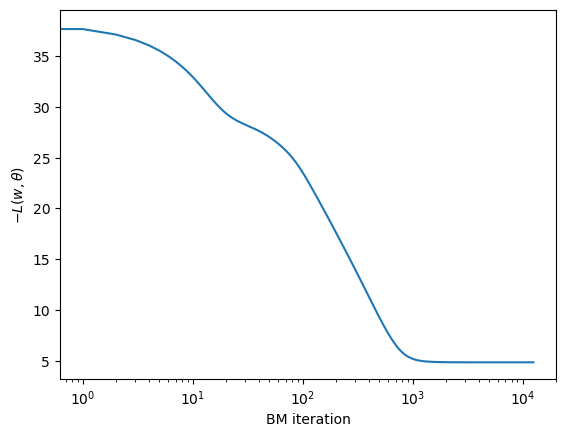

In [11]:
plt.plot(np.arange(bm._bm_it+1), -1*bm.log_likelihood_track)
plt.ylabel(r'$-L(w,\theta)$')
plt.xlabel('BM iteration')
#plt.yscale('log')
plt.xscale('log')


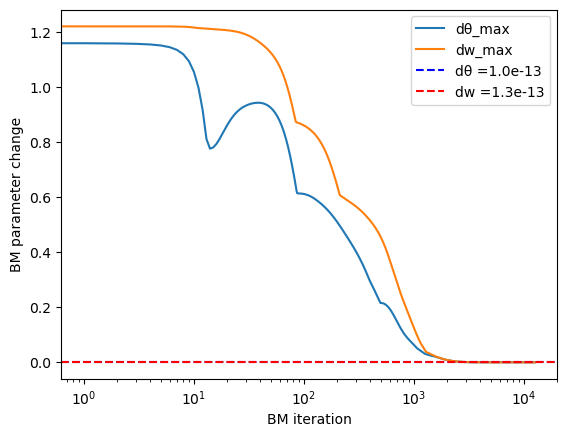

In [12]:
plt.plot(np.arange(bm._bm_it), bm.dθ_max_track, label='dθ_max')
plt.plot(np.arange(bm._bm_it), bm.dw_max_track, label='dw_max')
plt.ylabel('BM parameter change')
plt.xlabel('BM iteration')
#plt.yscale('log')
plt.xscale('log')
plt.axhline(y = bm.dθ_max_track[-1], linestyle='--', label= 'dθ =' +  str('{:.1e}'.format(bm.dθ_max_track[-1])), color='b')
plt.axhline(y = bm.dw_max_track[-1], linestyle='--', label= 'dw =' +  str('{:.1e}'.format(bm.dw_max_track[-1])), color='r')
plt.legend()

## Import Salamander

In [13]:
# importing the Salamander data

In [8]:
def give_rand_salamander_data(n_neuron = 10):
    n_rows = 160
    n_columns = 283041
    n_experiments = 297
    n_tpoints_per_experiment = 953
    
    selected_neurons = np.random.choice(n_rows, size = n_neuron,replace=False)
    selected_neurons = np.sort(selected_neurons)
    experiment_number = np.random.choice(n_experiments)

    selected_data = np.zeros((n_neuron, n_tpoints_per_experiment))
    all_data = np.zeros((n_neuron, n_columns)) # this is only for showing, not needed

    j = 0
    with open('bint.txt','rt') as file:
        for i, line in enumerate(file.readlines()):
            if i in selected_neurons:
                selected_data[j] = line.split()[experiment_number*n_tpoints_per_experiment:experiment_number*n_tpoints_per_experiment + n_tpoints_per_experiment]
                all_data[j] = line.split()
                j+=1
    return {'selected_data': (2.*selected_data-1).T, 'experiment_number': experiment_number, 'selected_neurons': selected_neurons, 'all_data': (2.*all_data-1).T}

In [9]:
sal_data = give_rand_salamander_data(10)
selected_data = sal_data['selected_data']
all_data = sal_data['all_data']
selected_neurons = sal_data['selected_neurons']

In [10]:
print(selected_data.shape)
print(all_data.shape)
print(selected_neurons)

(953, 10)
(283041, 10)
[  1   5  45  69  71  91  92 120 142 145]


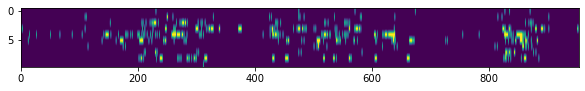

In [11]:
plt.figure(figsize=(10,5))
plt.imshow(selected_data.T, aspect=10)

## Part 2

Apply the exact algorithm to 10 randomly selected neurons from the 160 neurons
of the salamaner retina, as discussed in [Schneidman et al., 2006]. The origi-
nal data file has dimension 160 × 283041, which are 297 repeated experiments,
each of which has 953 time points. Use only one of these repeats for train-
ing the BM, ie. your data file for training has dimension 10 × 953. Reproduce
[Schneidman et al., 2006] fig 2a.

In [12]:
bm_sal = BM(selected_data)

In [13]:
η=0.001 # learning rate
max_bm_sal_it=700000
tolerance = 1e-3
α = 0.99 # momentum
method = 'exact'
option = None
#initialize_option='uniform'
initialize_option='gaussian'

In [14]:
result_sal = bm_sal.learn(η=η, max_bm_it=max_bm_sal_it, initialize_option=initialize_option, α = α, tolerance=tolerance, method=method, option=option)

BM reached the criteria


In [40]:
print('at the final step, max update is: ', '{:.1E}'.format(bm_sal.max_update))
print('convergence stat: ', bm_sal.convergence)
if bm_sal.convergence == False:
    print('if not converged, increase the max_bm_sal_it')

at the final step, max update is:  1.0E-03
convergence stat:  True


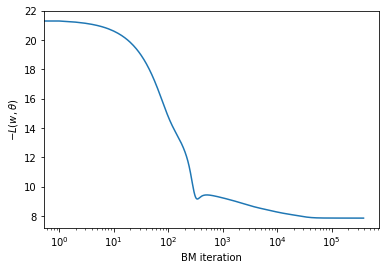

In [41]:
plt.plot(np.arange(bm_sal._bm_it+1), -1*bm_sal.log_likelihood_track)
plt.ylabel(r'$-L(w,\theta)$')
plt.xlabel('BM iteration')
#plt.yscale('log')
plt.xscale('log')


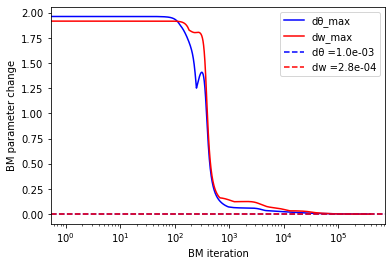

In [42]:
plt.plot(np.arange(bm_sal._bm_it), bm_sal.dθ_max_track, label='dθ_max', color='b')
plt.plot(np.arange(bm_sal._bm_it), bm_sal.dw_max_track, label='dw_max', color='r')

plt.ylabel('BM parameter change')
plt.xlabel('BM iteration')
#plt.yscale('log')
plt.xscale('log')
plt.axhline(y = bm_sal.dθ_max_track[-1], linestyle='--', label= 'dθ =' +  str('{:.1e}'.format(bm_sal.dθ_max_track[-1])), color='b')
plt.axhline(y = bm_sal.dw_max_track[-1], linestyle='--', label= 'dw =' +  str('{:.1e}'.format(bm_sal.dw_max_track[-1])), color='r')
plt.legend()

plotting a figure similar to figure 2a of paper

(1e-10, 100.0)

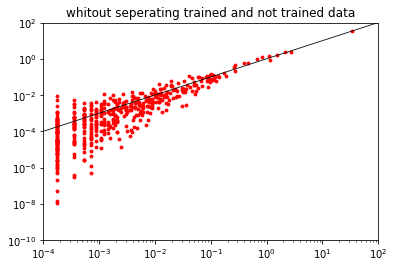

In [43]:
# observed rates
unique_data, true_counts = np.unique(all_data, axis=0,return_counts = True)
observed_rates = true_counts/(all_data.shape[0])

# predicted rates
# ps = lle.estimate(w, theta, unique_data)
predicted_rates = np.exp(give_log_likelihood_data(bm_sal.θ, bm_sal.w, unique_data))

Δτ = 2e-2

observed_rates = observed_rates*(1/Δτ) # this is also done in the paper. 
predicted_rates = predicted_rates*(1/Δτ)

plt.title('whitout seperating trained and not trained data')
plt.plot([1e-4, 1e2],[1e-4, 1e2], color='black', linewidth=.8)
plt.scatter(observed_rates, predicted_rates, s = 8, color = 'red')
plt.yscale('log')
plt.xscale('log')
plt.xlim((1e-4, 1e2))
plt.ylim((1e-10, 1e2))

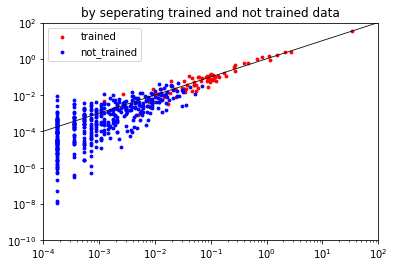

In [44]:
unique_trained = np.unique(selected_data,axis = 0)
indx_trained = []
indx_not_trained = []
for indx,dtmp in enumerate(unique_data):
        if (np.where(np.all(unique_trained == dtmp, axis = 1))[0].shape[0]) == 0:
            indx_not_trained.append(indx)
        else:
            indx_trained.append(indx)

plt.title('by seperating trained and not trained data')
plt.plot([1e-4, 1e2],[1e-4, 1e2], color='black', linewidth=.8)
plt.scatter(observed_rates[indx_trained], predicted_rates[indx_trained], s = 8, color = 'red', label='trained')
plt.scatter(observed_rates[indx_not_trained], predicted_rates[indx_not_trained], s = 8, color = 'b',label='not_trained')
plt.yscale('log')
plt.xscale('log')
plt.xlim((1e-4, 1e2))
plt.ylim((1e-10, 1e2))            
plt.legend()

## part 3

 For larger problems, implement a Metropolis Hasting
 sampling
 method using
single spin flips to estimate the free statistics hsi i , Dsi s j E
 in each learning step.
Produce a plot of the likelihood over learning iterations that compares the ac-
curacy of your sampled gradient with the exact evaluation of the gradient for
small systems. Investigate how many Monte Carlo samples are required so that
the gradients are sufficiently accurate for the BM learning. Since the gradient is
not exact and fluctuates from iteration to iteration, a convergence criterion is less
straightforward. Propose a convergence criterion.

- here because statistic and updates are computed by sampling, they are not exact and have noise. therefore, in order to find convergence, it is better to consider the changes on the paramter averaged over some number. 
- by investigating different number of samples for MH algorithm, it is better to have more than 2000 samples. here we have chosen 4000 samples

In [18]:
bm_sal = BM(selected_data)

In [19]:
η=0.001 # learning rate
max_bm_sal_it=7000000
tolerance = 1e-2
α = 0.99 # momentum
method = 'MH'
option = {'n_samples':5000, 'n_grad':20}
initialize_option='gaussian'
#initialize_option='uniform'


In [20]:
result_sal = bm_sal.learn(η=η, max_bm_it=max_bm_sal_it, initialize_option=initialize_option, α = α, tolerance=tolerance, method=method, option=option)

BM reached the criteria


In [21]:
print('at the final step, average max update is: ', '{:.1E}'.format(bm_sal.max_update))
print('convergence stat: ', bm_sal.convergence)
if bm_sal.convergence == False:
    print('if not converged, increase the max_bm_sal_it')

at the final step, average max update is:  9.7E-03
convergence stat:  True


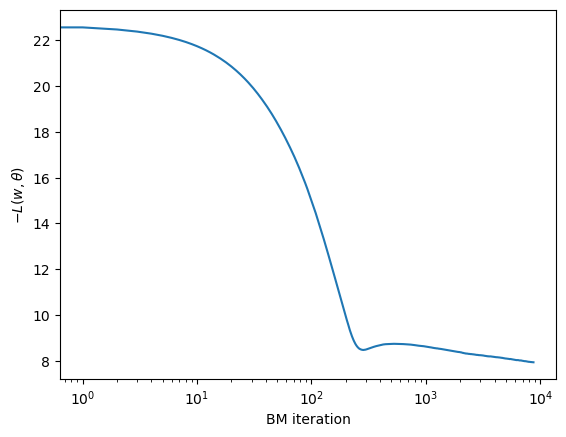

In [22]:
plt.plot(np.arange(bm_sal._bm_it+1), -1*bm_sal.log_likelihood_track)
plt.ylabel(r'$-L(w,\theta)$')
plt.xlabel('BM iteration')
#plt.yscale('log')
plt.xscale('log')


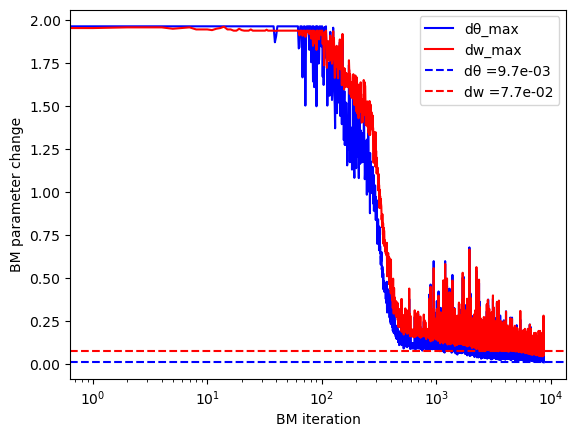

In [23]:
plt.plot(np.arange(bm_sal._bm_it), bm_sal.dθ_max_track, label='dθ_max', color='b')
plt.plot(np.arange(bm_sal._bm_it), bm_sal.dw_max_track, label='dw_max', color='r')

plt.ylabel('BM parameter change')
plt.xlabel('BM iteration')
#plt.yscale('log')
plt.xscale('log')
plt.axhline(y = bm_sal.dθ_max_track[-1], linestyle='--', label= 'dθ =' +  str('{:.1e}'.format(bm_sal.dθ_max_track[-1])), color='b')
plt.axhline(y = bm_sal.dw_max_track[-1], linestyle='--', label= 'dw =' +  str('{:.1e}'.format(bm_sal.dw_max_track[-1])), color='r')
plt.legend()

## part 4

Repeat the previous step, where you replace the MH sampling method by the ⟨ ⟩ mean ﬁeld + linear response method to estimate the free statistics 〈s i 〉 , s i s j . For a small toy data problem (n = 10 − 20), produce a plot where you compare the likelihood versus learning iteration for the MH and MF approximations with the exact learning method.

- as I have tested using MF approximations, with salamander data, it does not work very good, it can give a descent result, but not perfect. after some large number of iteration, the minus loglikelihood starts going up. 

In [105]:
bm_sal = BM(selected_data)

In [108]:
η=0.001 # learning rate
max_bm_sal_it=70000
tolerance = 1e-2
α = 0.99 # momentum
method = 'MF_LR'
#option = {'n_samples':5000, 'n_grad':20}option['error_criteria'], α_MF=option['α_MF'], maxiter=option['maxiter']
option = {'error_criteria':1e-10, 'α_MF':.8, 'maxiter':20000, 'n_grad':1000, 'solve_MF':'simple'}
initialize_option='gaussian'
#initialize_option='uniform'


In [109]:
result_sal = bm_sal.learn(η=η, max_bm_it=max_bm_sal_it, initialize_option=initialize_option, α = α, tolerance=tolerance, method=method, option=option)

BM reached the criteria


In [110]:
#print(bm_sal.log_likelihood_track[-100])

In [111]:
print('at the final step, average max update is: ', '{:.1E}'.format(bm_sal.max_update))
print('convergence stat: ', bm_sal.convergence)
if bm_sal.convergence == False:
    print('if not converged, increase the max_bm_sal_it')

at the final step, average max update is:  1.0E-02
convergence stat:  True


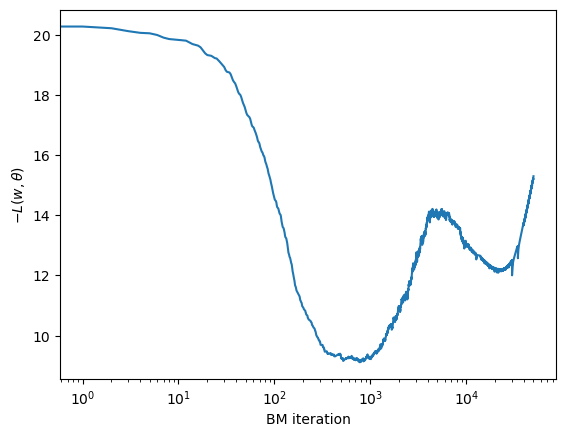

In [112]:
plt.plot(np.arange(bm_sal._bm_it+1), -1*bm_sal.log_likelihood_track)
plt.ylabel(r'$-L(w,\theta)$')
plt.xlabel('BM iteration')
#plt.yscale('log')
plt.xscale('log')


In [113]:
print(bm_sal.max_update_track)

[]


IndexError: index -1 is out of bounds for axis 0 with size 0

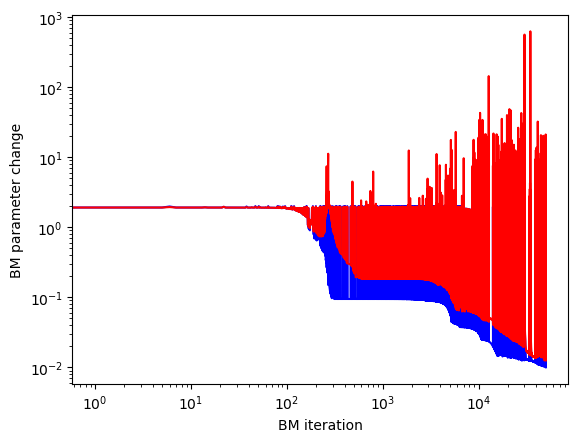

In [114]:
plt.plot(np.arange(bm_sal._bm_it), bm_sal.dθ_max_track, label='dθ_max', color='b')
plt.plot(np.arange(bm_sal._bm_it), bm_sal.dw_max_track, label='dw_max', color='r')

plt.ylabel('BM parameter change')
plt.xlabel('BM iteration')
plt.yscale('log')
plt.xscale('log')
plt.axhline(y = bm_sal.max_update_track[-1], linestyle='--', label= 'max_update =' +  str('{:.1e}'.format(bm_sal.max_update[-1])), color='b')
#plt.axhline(y = bm_sal.dw_max_track[-1], linestyle='--', label= 'dw =' +  str('{:.1e}'.format(bm_sal.dw_max_track[-1])), color='r')
plt.legend()

In [53]:
# observed rates
unique_data, true_counts = np.unique(all_data, axis=0,return_counts = True)
observed_rates = true_counts/(all_data.shape[0])

# predicted rates
#ps = lle.estimate(w, theta, unique_data)
predicted_rates = np.exp(give_log_likelihood_data(bm_sal.θ, bm_sal.w, unique_data))

Δτ = 2e-2

observed_rates = observed_rates*(1/Δτ) # this is also done in the paper. 
predicted_rates = predicted_rates*(1/Δτ)


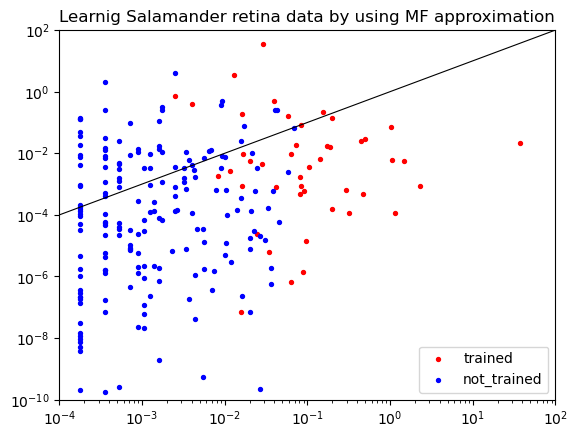

In [56]:
unique_trained = np.unique(selected_data,axis = 0)
indx_trained = []
indx_not_trained = []
for indx,dtmp in enumerate(unique_data):
        if (np.where(np.all(unique_trained == dtmp, axis = 1))[0].shape[0]) == 0:
            indx_not_trained.append(indx)
        else:
            indx_trained.append(indx)

plt.title('Learnig Salamander retina data by using MF approximation')
plt.plot([1e-4, 1e2],[1e-4, 1e2], color='black', linewidth=.8)
plt.scatter(observed_rates[indx_trained], predicted_rates[indx_trained], s = 8, color = 'red', label='trained')
plt.scatter(observed_rates[indx_not_trained], predicted_rates[indx_not_trained], s = 8, color = 'b',label='not_trained')
plt.yscale('log')
plt.xscale('log')
plt.xlim((1e-4, 1e2))
plt.ylim((1e-10, 1e2))            
plt.legend()

- now lets use MF approximation for a small toy model of n=10-20

In [ ]:
sal_data = give_rand_salamander_data(10)
selected_data = sal_data['selected_data']
all_data = sal_data['all_data']
selected_neurons = sal_data['selected_neurons']

## part 6: finding the solution from directly solving the fixed point equation. 


In [27]:
m = bm_sal._clamped_stat['sigma'][0]
C = bm_sal._clamped_stat['sigma_sigma'] - np.outer(m, m)


In [56]:
from tqdm import tqdm
epsilon_list =  np.arange(0.0,10,0.0001)
listsize = len(epsilon_list)
loglikelist =  np.zeros(listsize)
for i in tqdm(range(listsize)):
    epsilon = epsilon_list[i]
    C_epsilon = C + epsilon*np.eye(C.shape[0])
    C_epsilon_inv = np.linalg.inv(C_epsilon)
    w = np.diag(1/(1-m**2))-C_epsilon_inv
    w = w - np.diag(np.diag(w))
    theta = np.arctanh(m) - w@m
    
    loglikelist[i] = give_log_likelihood(theta.reshape((C.shape[0],1)), w, selected_data)

100%|██████████| 100000/100000 [00:12<00:00, 8033.07it/s]


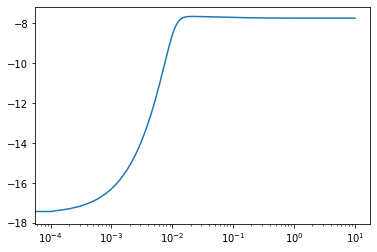

In [57]:
plt.plot(epsilon_list, loglikelist)
plt.xscale('log')

In [41]:
print(w.shape)
print(theta.shape)
print(selected_data.shape)
give_log_likelihood_data(theta.reshape(10,1), w, selected_data)

(10, 10)
(10,)
(953, 10)


array([-1.88931766e+01, -1.64265077e+01, -1.88931766e+01, -1.64265077e+01,
       -1.64265077e+01, -1.64265077e+01, -1.64265077e+01, -1.64265077e+01,
       -1.64265077e+01, -1.64265077e+01, -1.64265077e+01, -1.64265077e+01,
       -1.90918933e+01, -1.64265077e+01, -1.85072963e+01, -1.64265077e+01,
       -1.64265077e+01, -1.64265077e+01, -1.64265077e+01, -1.64265077e+01,
       -1.64265077e+01, -1.64265077e+01, -1.64265077e+01, -1.64265077e+01,
       -1.64265077e+01, -1.64265077e+01, -1.85072963e+01, -1.64265077e+01,
       -1.64265077e+01, -1.64265077e+01, -1.64265077e+01, -1.64265077e+01,
       -1.64265077e+01, -1.64265077e+01, -1.64265077e+01, -1.64265077e+01,
       -1.64265077e+01, -1.64265077e+01, -1.64265077e+01, -1.64265077e+01,
       -1.64265077e+01, -1.64265077e+01, -1.64265077e+01, -1.64265077e+01,
       -1.64265077e+01, -1.64265077e+01, -1.64265077e+01, -1.64265077e+01,
       -1.64265077e+01, -1.64265077e+01, -1.85072963e+01, -1.64265077e+01,
       -1.64265077e+01, -